In [1]:
%reload_ext autoreload
%autoreload 2
import os
import time
from absl import logging
from typing import Any
from functools import partial

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state
import optax

import tensorflow as tf
import tensorflow_datasets as tfds

from ml_collections import ConfigDict

%cd /hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg
%ls

# Import custom modules
from src.loss import l2_loss
from src.vqvae import VQVAE

2024-05-29 23:03:39.337390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg
config/       nets.ipynb  test1.ipynb        train_token.ipynb
layers.ipynb  src/        tf_datasets.ipynb


/hildafs/projects/phy230056p/junzhez/.conda/envs/AI_torch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Data (we do not need label)

In [2]:
# Directory to save images
data_dir = '/hildafs/projects/phy230056p/junzhez/data/'
data_name = 'mnist'
save_dir = os.path.join(data_dir, data_name)
os.makedirs(save_dir, exist_ok=True)

# Load MNIST dataset using TensorFlow Datasets
dataset_name = 'mnist'
train_split = 'train[:80%]'
val_split = 'train[80%:]'
test_split = 'test'

train_dataset, train_info = tfds.load(dataset_name, data_dir=save_dir, split=train_split, with_info=True)
val_dataset = tfds.load(dataset_name, data_dir=save_dir, split=val_split)
test_dataset = tfds.load(dataset_name, data_dir=save_dir, split=test_split)

# Preprocess dataset
def preprocess(sample):
    image = sample['image']
    image = tf.cast(image, tf.float32) / 255.0
    return {'image': image}

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Convert to numpy arrays and batch the data
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

2024-05-29 23:03:42.976765: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2024-05-29 23:03:43.847936: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 23:03:43.890792: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 23:03:43.926446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

shape = (batch, height, width, channels)
Train data shape: (32, 28, 28, 1)
Val data shape: (32, 28, 28, 1)
Test data shape: (32, 28, 28, 1)


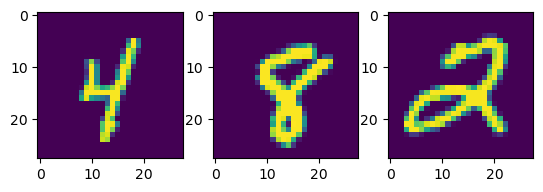

In [3]:
# example training, validation, and test data
train_example = next(iter(train_dataset.as_numpy_iterator()))
val_example = next(iter(val_dataset.as_numpy_iterator()))
test_example = next(iter(test_dataset.as_numpy_iterator()))

print('shape = (batch, height, width, channels)')
print(f"Train data shape: {train_example['image'].shape}")
print(f"Val data shape: {val_example['image'].shape}")
print(f"Test data shape: {test_example['image'].shape}")

# plot example data
fig, axs = plt.subplots(1, 3)
axs[0].imshow(train_example['image'][0])
axs[1].imshow(val_example['image'][0])
axs[2].imshow(test_example['image'][0])
plt.show()

# Config

In [4]:
# Create the VQVAE model configuration
config = ConfigDict()
config.vqvae = ConfigDict()

# encoder configs
config.vqvae.filters = 64
config.vqvae.num_res_blocks = 2
config.vqvae.channel_multipliers = [1, 1, 2]
config.vqvae.embedding_dim = 32 # output dimension of the encoder
config.vqvae.conv_downsample = False # whether to use convolutional downsampling or average pooling downsampling in the encoder/decoder
config.vqvae.conv_fn = "conv" # the standard convolutional layer in the residual block, and in the encoder (flax.linen.Conv)
config.vqvae.norm_type = "GN" # normalization layer in the residual block, default to group norm so we don't need to keep track of running statistics
config.vqvae.activation_fn = "swish" # activation function in the residual block, and in the encoder

# additional decoder configs
config.vqvae.output_dim = 1 # N of decoder output channels = N color channels 

# quantizer configs
config.vqvae.codebook_size = 256
config.vqvae.commitment_cost = 0.25

# quantizer's entropy loss configs
config.vqvae.entropy_loss_ratio = 0.1
config.vqvae.entropy_temperature = 0.01
config.vqvae.entropy_loss_type = "softmax"

# Training

In [ ]:
# Define the model
model = VQVAE(config=config, train=True, dtype=jnp.float32)

# Initialize parameters
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
input_sample = next(iter(train_dataset))['image']
params = model.init(init_rng, {'image': input_sample})

# Setup optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer,
)

# Define the loss function
def loss_fn(params, batch):
    image = batch['image']
    reconstructed, result_dict = model.apply(params, {'image': image})
    reconstruction_loss = jnp.mean((reconstructed - image) ** 2)
    quantizer_loss = result_dict['quantizer_loss']
    total_loss = quantizer_loss + reconstruction_loss
    return total_loss, (reconstructed, result_dict)

# Define the training step
@jax.jit
def train_step(state, batch, rng):
    rng, new_rng = jax.random.split(rng)
    (loss, (reconstructed, result_dict)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, new_rng, loss, reconstructed, result_dict

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_dataset.as_numpy_iterator():
        state, rng, loss, reconstructed, result_dict = train_step(state, batch, rng)
        print(f'Epoch {epoch}, Loss: {loss}')

# Save the model parameters if necessary
# jax.jax.save('/path/to/save/model_params.pkl', state.params)

In [20]:
state.params

{'params': {'decoder': {'Conv_0': {'bias': Array([ 8.08151886e-02, -3.44828106e-02,  6.03296943e-02, -7.94509500e-02,
            5.15454561e-02,  1.19241901e-01, -7.64233842e-02, -5.85227497e-02,
           -9.63540399e-04,  6.71869442e-02, -4.04472090e-02, -4.94632944e-02,
            3.80870365e-02,  5.19496128e-02, -5.26400879e-02, -4.02733423e-02,
            1.15038753e-02, -3.63718864e-05, -1.92296188e-02,  1.93106029e-02,
           -4.22594510e-02, -3.75800766e-02,  2.86395922e-02,  9.41739306e-02,
           -6.53785393e-02, -8.10807422e-02,  9.94777009e-02,  2.36246567e-02,
           -5.44910990e-02, -5.32996561e-03,  2.81446315e-02,  2.21770536e-02,
            6.38629310e-03, -4.70147934e-03, -3.05644926e-02,  2.07238123e-02,
            4.60549742e-02, -1.82373375e-02,  2.65236548e-03, -3.69867012e-02,
            6.51556030e-02, -1.19759403e-01,  4.69281711e-02,  1.21810064e-02,
           -9.57366154e-02,  3.36849578e-02,  1.02720233e-02,  3.22645903e-02,
           -1

2024-05-29 23:22:55.860030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


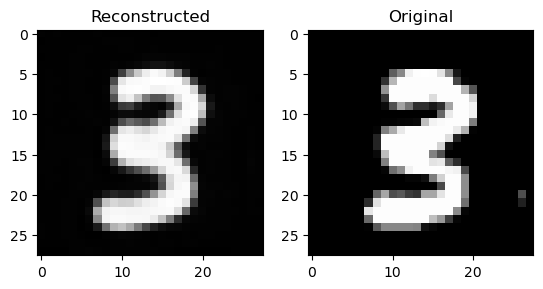

In [21]:
# Evaluate on the validation set
model_eval = VQVAE(config=config, train=False, dtype=jnp.float32)
for batch in val_dataset.as_numpy_iterator():
    reconstructed, result_dict = model_eval.apply(state.params, batch)
    # Visualization or calculation of validation metrics here

# Visualize some results
fig, axs = plt.subplots(1, 2)
axs[0].imshow(reconstructed[0], cmap='gray')
axs[0].title.set_text('Reconstructed')
axs[1].imshow(batch['image'][0], cmap='gray')
axs[1].title.set_text('Original')
plt.show()


In [15]:
def create_train_state(rng, config):
    """Create initial training state."""
    model = VQVAE(config=config)
    params = model.init(rng, jnp.ones([1, 28, 28, 1]), train=True)['params']
    tx = optax.adam(learning_rate=0.001)
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
    """Perform a single training step."""

    def loss_fn(params):
        logits, losses = state.apply_fn({'params': params}, batch['image'], train=True)
        return losses['quantizer_loss'], logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, logits

@jax.jit
def eval_step(state, batch):
    """Evaluate the model on a batch of data."""
    logits, _ = state.apply_fn({'params': state.params}, batch['image'], train=False)
    return logits

def train_epoch(state, train_ds, batch_size, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # Drop incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = 0
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, loss, logits = train_step(state, batch)
        epoch_loss += loss

    epoch_loss /= steps_per_epoch
    return state, epoch_loss

In [16]:
def visualize_reconstructions(state, batch, epoch, num_images=10):
    """Visualize reconstructed images."""
    reconstructed_images = eval_step(state, batch)
    fig, axs = plt.subplots(2, num_images, figsize=(10, 2))
    for i in range(num_images):
        axs[0, i].imshow(batch['image'][i].squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axs[1, i].axis('off')
    plt.savefig(f"{save_dir}/reconstructions_epoch_{epoch}.png")
    plt.close()

# Initialize random number generator
rng = jax.random.PRNGKey(0)

# Create training state
state = create_train_state(rng, config)

# Train for a number of epochs
num_epochs = 10
for epoch in range(num_epochs):
    rng, input_rng = jax.random.split(rng)
    state, train_loss = train_epoch(state, train_dataset, batch_size, input_rng)
    print(f"Epoch {epoch} training loss: {train_loss:.4f}")

    # Visualize reconstructions
    sample_batch = next(iter(train_dataset))  # Take a sample batch from the dataset
    visualize_reconstructions(state, sample_batch, epoch)

TypeError: VQVAE.__init__() missing 1 required positional argument: 'train'

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """Train for a single epoch."""
    train_loss = []
    for batch in train_ds:
        rng, new_rng = jax.random.split(rng)
        x = batch['image']

        def loss_fn(params):
            logits, outputs = vq_model.apply({'params': params}, x, rngs={'dropout': rng})
            loss = outputs['quantizer_loss']
            return loss, outputs

        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, outputs), grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)
        train_loss.append(loss)

        # Optionally, log or print loss here

    return state, np.mean(train_loss)

# Training loop
rng = jax.random.PRNGKey(0)
num_epochs = 10

for epoch in range(num_epochs):
    rng, new_rng = jax.random.split(rng)
    state, train_loss = train_epoch(state, train_dataset, batch_size, epoch, rng)
    print(f'Epoch {epoch}, Train Loss: {train_loss}')


# Scratch

In [12]:
# Create the VQVAE model
vqvae = VQVAE(config=config, train=True)

In [15]:
# Define a simple training state to hold the model and optimizer
class TrainState(train_state.TrainState):
    batch_stats: Any = None

def create_train_state(rng, config, learning_rate):
    vqvae = VQVAE(config=config, train=True)
    variables = vqvae.init(rng, {'image': jnp.ones([1, 28, 28, 1]), 'train': True})
    params = variables['params']
    batch_stats = variables['batch_stats']
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=vqvae.apply, params=params, tx=tx, batch_stats=batch_stats)

def l2_loss(y_true, y_pred):
    # y_true has shape (batch_size, height, width, color_channels=1)
    diff = y_true - y_pred
    diff = jnp.asarray(diff, jnp.float32)
    return jnp.mean(jnp.square(diff))

# Training step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        result, new_model_state = state.apply_fn(variables, {'image': batch, 'train': True}, mutable=['batch_stats'])
        reconstructions, result_dict = result
        # result_dict has keys: 
        # dict_keys(['quantizer_loss', 'e_latent_loss', 'q_latent_loss', 'entropy_loss', 'encodings', 'encoding_indices', 'raw'])
        recon_loss = l2_loss(batch, reconstructions)
        quantizer_loss = result_dict['quantizer_loss']
        total_loss = recon_loss + quantizer_loss
        return total_loss, (recon_loss, quantizer_loss, new_model_state)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (total_loss, (recon_loss, quantizer_loss, new_model_state)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=new_model_state['batch_stats'])
    return state, total_loss, recon_loss, quantizer_loss



# Validation step
@jax.jit
def eval_step(state, batch):
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    print(variables.keys()) # dict_keys(['params', 'batch_stats'])

    print(variables['params'].keys()) # dict_keys(['decoder', 'encoder', 'quantizer'])
    print(variables['params']['decoder'].keys()) # dict_keys(['BatchNorm_0', 'Conv_0', 'Conv_1', 'Conv_2', 'Conv_3', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
    print(variables['params']['encoder'].keys()) # dict_keys(['BatchNorm_0', 'Conv_0', 'Conv_1', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
    print(variables['params']['quantizer'].keys()) # dict_keys(['codebook'])

    print(variables['batch_stats'].keys()) # dict_keys(['decoder', 'encoder'])
    print(variables['batch_stats']['decoder'].keys()) # dict_keys(['BatchNorm_0', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
    print(variables['batch_stats']['encoder'].keys()) # dict_keys(['BatchNorm_0', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])

    # access train in variables
    reconstructions, _ = state.apply_fn(variables, {'image': batch, 'train': False}, mutable=False)
    recon_loss = l2_loss(batch, reconstructions)
    quantizer_loss = 0  # Assuming quantizer_loss is not required during evaluation
    total_loss = recon_loss + quantizer_loss
    return total_loss, recon_loss, quantizer_loss



def train_and_evaluate(config, train_dataset, val_dataset, num_epochs, learning_rate):
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, config, learning_rate)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training
        for batch in train_dataset.as_numpy_iterator():
            state, total_loss, recon_loss, quantizer_loss = train_step(state, batch)
        
        # Validation
        val_loss = 0
        val_recon_loss = 0
        val_quantizer_loss = 0
        val_steps = 0
        for batch in val_dataset.as_numpy_iterator():
            loss, recon_loss, quantizer_loss = eval_step(state, batch)
            val_loss += loss
            val_recon_loss += recon_loss
            val_quantizer_loss += quantizer_loss
            val_steps += 1
        val_loss /= val_steps
        val_recon_loss /= val_steps
        val_quantizer_loss /= val_steps

        epoch_time = time.time() - start_time
        print(
            f"Epoch {epoch+1}, Time: {epoch_time:.2f}s, "
            f"Train Loss: {total_loss:.4f}, "
            f"Validation Loss: {val_loss:.4f}, "
            f"Recon Loss: {val_recon_loss:.4f}, "
            f"Quantizer Loss: {val_quantizer_loss:.4f}"
        )



# Start training
num_epochs = 10
learning_rate = 1e-3

train_and_evaluate(config, train_dataset, val_dataset, num_epochs, learning_rate)

2024-05-29 02:50:51.788571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


dict_keys(['params', 'batch_stats'])
dict_keys(['decoder', 'encoder', 'quantizer'])
dict_keys(['decoder', 'encoder'])
dict_keys(['BatchNorm_0', 'Conv_0', 'Conv_1', 'Conv_2', 'Conv_3', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
dict_keys(['BatchNorm_0', 'Conv_0', 'Conv_1', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
dict_keys(['codebook'])
dict_keys(['BatchNorm_0', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
dict_keys(['BatchNorm_0', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])


2024-05-29 02:50:52.039960: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ModifyScopeVariableError: Cannot update variable "mean" in "/encoder/ResBlock_0/BatchNorm_0" because collection "batch_stats" is immutable. (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ModifyScopeVariableError)

In [16]:
rng = jax.random.PRNGKey(0)
state = create_train_state(rng, config, learning_rate)

In [20]:
state.__dict__.keys()

dict_keys(['step', 'apply_fn', 'params', 'tx', 'opt_state', 'batch_stats'])

In [23]:
state.params.keys()

dict_keys(['encoder', 'quantizer', 'decoder'])

In [5]:
# Define a simple training state to hold the model and optimizer
class TrainState(train_state.TrainState):
    batch_stats: Any = None

def create_train_state(rng, config, learning_rate):
    vqvae = VQVAE(config=config, train=True)
    variables = vqvae.init(rng, {'image': jnp.ones([1, 28, 28, 1]), 'train': True})
    params = variables['params']
    batch_stats = variables['batch_stats']
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=vqvae.apply, params=params, tx=tx, batch_stats=batch_stats)


def l2_loss(y_true, y_pred):
    diff = y_true - y_pred
    diff = jnp.asarray(diff, jnp.float32)
    return jnp.mean(jnp.square(diff))


# Training step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        outputs, new_model_state = state.apply_fn(
            variables, {'image': batch, 'train': True}, mutable=['batch_stats']
        )
        reconstructions, quantizer_loss = outputs
        recon_loss = l2_loss(batch, reconstructions)
        total_loss = recon_loss + quantizer_loss
        return total_loss, (recon_loss, quantizer_loss), new_model_state
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (total_loss, (recon_loss, quantizer_loss), new_model_state), grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
    return new_state, total_loss, recon_loss, quantizer_loss


# Validation step
@jax.jit
def eval_step(state, batch):
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    outputs = state.apply_fn(
        variables, {'image': batch, 'train': False}, mutable=False
    )
    reconstructions, quantizer_loss = outputs
    recon_loss = l2_loss(batch, reconstructions)
    total_loss = recon_loss + quantizer_loss
    return total_loss, recon_loss, quantizer_loss


def train_and_evaluate(config, train_dataset, val_dataset, num_epochs, learning_rate):
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, config, learning_rate)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training
        for batch in train_dataset.as_numpy_iterator():
            state, total_loss, recon_loss, quantizer_loss = train_step(state, batch)
        
        # Validation
        val_loss = 0
        val_recon_loss = 0
        val_quantizer_loss = 0
        val_steps = 0
        for batch in val_dataset.as_numpy_iterator():
            loss, recon_loss, quantizer_loss = eval_step(state, batch)
            val_loss += loss
            val_recon_loss += recon_loss
            val_quantizer_loss += quantizer_loss
            val_steps += 1
        val_loss /= val_steps
        val_recon_loss /= val_steps
        val_quantizer_loss /= val_steps

        epoch_time = time.time() - start_time
        logging.info(
            f"Epoch {epoch+1}, Time: {epoch_time:.2f}s, "
            f"Train Loss: {total_loss:.4f}, "
            f"Validation Loss: {val_loss:.4f}, "
            f"Recon Loss: {val_recon_loss:.4f}, "
            f"Quantizer Loss: {val_quantizer_loss:.4f}"
        )


# Start training
num_epochs = 10
learning_rate = 1e-3

train_and_evaluate(config, train_dataset, val_dataset, num_epochs, learning_rate)

2024-05-29 01:55:55.130233: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: too many values to unpack (expected 2)